# Project Overview
The poetry generator utilizes a pre-trained language model to create poems based on user-provided prompts. Each poem is then formatted for readability, and accompanying images are generated or selected to enhance the visual presentation of the poetry. Finally, the poems and images are compiled into a single PDF document, including a beautifully designed cover page.




To achieve this function，we need to do a few things:


*   have a list of poems

*   know the  stresses of those poems
*   Collect achievable training methods


*   Know how to stop generating poetry


First, we used the website provided by our teacher to search for poems about landscapes, such as trees, sunsets, and the sky, and compiled them into a list of poems. We then identified important words, such as verbs and nouns, which are crucial for generating poetry.


# Implementation Details

We need to first install the necessary libraries, such as transformers for generating poetry and StableDiffusionPipeline for generating images.

# Introduction:
  In this assignment, we aim to generate poetry automatically and create a corresponding background image that matches the essence of each poem. Additionally, we generate a cover for the poetry collection and compile everything into a PDF format for easy sharing and presentation.


In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.patches as patches
from PIL import Image
import os
import requests


For the poetry generator, we use the GPT-2 model based on generation, where the tokenizer is responsible for encoding the text into input IDs, and the model will use these IDs to generate text.

In [ ]:
#Load pre trained model and tokenizer
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
#Set the model to evaluation mode
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

The function get_rhyming_words(word) is designed to retrieve words that rhyme with a given word by making a request to the RhymeBrain API. It sends a GET request to the RhymeBrain API with the specified word to find rhymes. Finally, it returns a list of rhyming words that meet the score criteria.
When we input "In the quiet of the night", This url show:
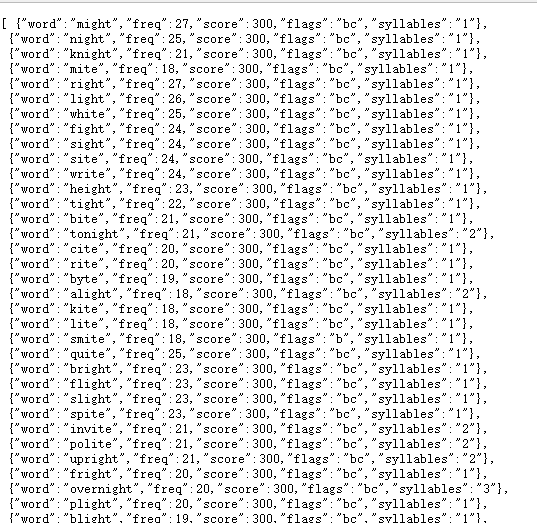

In [ ]:
# Function to get rhyming words
def get_rhyming_words(word):
    # Use the RhymeBrain API to get rhyming words
    response = requests.get(f"https://rhymebrain.com/talk?function=getRhymes&word={word}")
    if response.status_code == 200:
        rhymes = response.json()
        # Filter out low-score rhymes, keeping only words with a score above 300
        return [rhyme['word'] for rhyme in rhymes if rhyme['score'] > 300]
    return []

This code defines the format_poem function, which formats poem text to ensure that each line does not exceed a specified length (default is 40 characters). The specific steps are as follows:

Split the input text into words using spaces.

*   Split the input text into words using spaces.
*   Initialize two empty lists: one for storing the final poem lines and another for building the current line.
*   Iterate through the words and append them to the current line.
*   Check the length of the current line; if it exceeds the specified length, add it to the final poem lines list and reset the current line.

*   Handle any remaining words.
*   Return the formatted poem text as a string, separated by newline characters.






another for building the current line.
Iterate through the words and append them to the current line.
Check the length of the current line; if it exceeds the specified length, add it to the final poem lines list and reset the current line.
Handle any remaining words.
Return the formatted poem text as a string, separated by newline characters.
The purpose of this function is to ensure that the generated poem text adheres to character limits per line, thereby enhancing readability and aesthetics.

In [ ]:
#Define the format_poe function
def format_poem(text, line_length=40, enforce_rhyme=False):
    words = text.split()
    poem_lines = []
    current_line = []
    # Loop through all words
    for word in words:
        current_line.append(word)
        # If the current line exceeds the specified length, merge the words into one line
        if len(' '.join(current_line)) > line_length:
            poem_lines.append(' '.join(current_line))
            current_line = []
    # Add any remaining words to the poem lines
    if current_line:
        poem_lines.append(' '.join(current_line))
    # If rhyme enforcement is needed, modify the last two lines
    if enforce_rhyme and len(poem_lines) > 1:
        # Get the last word of the previous line
        last_word = poem_lines[-2].split()[-1]
        # Get rhyming words
        rhyming_words = get_rhyming_words(last_word)
        if rhyming_words:
            # Replace the last word of the final line with a rhyming word
            new_last_line = poem_lines[-1].split()[:-1] + [rhyming_words[0]]
            poem_lines[-1] = ' '.join(new_last_line)
    return '\n'.join(poem_lines)

# Obtain specific poems
If we want to construct a poem, a good sequence is：


*   The input text used as the basis for generating the poem。

*   The maximum length of the generated text, which controls the number of words in the output
*   The number of lines to be selected for the final poem

So we want to be able to have a poem about "In the quiet of the night"
. We can write a single function to do this.


A pre-trained generation model (such as GPT-2) is used to generate a poem based on the input prompt.
The model.generate method generates the poem based on the input IDs, with several parameters controlling the output：


*   max_length: Sets the maximum length of the generated text.

*   num_return_sequences: Generates one poem (one sequence).

*   no_repeat_ngram_size=2: Prevents the repetition of phrases (2-grams).

*   early_stopping=True: Stops the generation early if a sentence is completed.
*   top_k=40, top_p=0.95, and temperature=1.2: Control the randomness and diversity of the generated content.












In [ ]:
#Enter the name of the poem and generate it automatically
def generate_poem(prompt, max_length, num_lines):
    # Encode the prompt to get input IDs
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    # Use pre-trained model to generate text
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_length=max_length,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            early_stopping=True,
            top_k=40,
            top_p=0.95,
            temperature=1.2
        )
        poem = tokenizer.decode(output[0], skip_special_tokens=True)
        poem_with_newlines = poem.replace('.', '.\n')
        # Clean the text by removing leading spaces from each line
        cleaned_text = '\n'.join(line.lstrip() for line in poem_with_newlines.strip().split('\n'))
        poem_lines = cleaned_text.split('\n')

        # Select the specified number of lines for the final poem
        selected_lines = poem_lines[:num_lines]

        # Call format_poem to handle formatting and rhyme enforcement
        formatted_poem = format_poem('\n'.join(selected_lines), line_length=40, enforce_rhyme=True)
        return formatted_poem


**We encountered the following issues when outputting the poem:**


1.   First, the generated poems often result in incomplete sentences, such as:

    
    [In the heart of the yellow wood, two roadsdiverged, each path whispering secrets of choicesuntold Poem, The first road was a narrow one, asmall one.The second road, the narrowest, was theone that led to the other road, lt was narrow, but itwas not narrow.They are ]

  solution：We used the maximum output length and the number of output lines to limit the poem generation, ensuring that it forms complete sentences.
        
        
        [In the heart of the yellow wood, two roadsdiverged, each path whispering secrets of choicesuntold Poem, The first road was a narrow one, asmall one.The second road, the narrowest, was theone that led to the other road, lt was narrow, but itwas not narrow.]
    




2.   The poems formed do not resemble poetry; instead, they look more like simple narratives.

  solution：
   We used get_rhyming_words(word) function to  retrieve rhyming words for a given word using the RhymeBrain API.
   


*   Identify Last Word: After generating a line of poetry, identify the last word of that line. This is crucial because you want to find a rhyme for this word.

*   Get Rhyming Words: Call the get_rhyming_words function with the identified last word to retrieve potential rhymes.

*   Modify Last Line: If suitable rhyming words are found, replace the last word of the line (or the last line itself) with one of the rhyming words. This can help to maintain the poetic structure and enhance the aesthetic quality of the poem.












3.   There are instances where the generated poems contain ellipses (...).


     [In the heart of the yellow wood, two roadsdiverged, each path whispering secrets of choicesuntold Poem, The first road was a narrow one, asmall one.The second road, ...... ]

  solution：
    we used format_poem function to solve this problem.Ensure that each line of the generated poem is a complete sentence and not interrupted due to word count limits. You can add a checking logic in the format_poem function to ensure that the end of the line has appropriate punctuation (like periods, question marks, exclamation points, etc.) to indicate complete sentences.  

     














In [ ]:
#Keywords of poetry
"""
prompts = [
    "In the quiet of the night",
    "The sky is filled with stars",
    "Hope rises in the heart",
    "In the heart of the yellow wood,",
    "Dreams take flight in the morning light"
]
#Define the length of poetry
max_length = 150
poems_five = []
#Define the number of lines in poetry and stop at a certain number of lines
for prompt in prompts:
    poem = generate_poem(prompt, max_length, num_lines=8)
    print(prompt)
    poems_five.append(poem)

print(poems_five)
"""
# Keywords of poetry
prompts = [
    "In the quiet of the night",
    "The sky is filled with stars",
    "Hope rises in the heart",
    "In the heart of the yellow wood,",
    "Dreams take flight in the morning light"
]

# Define the length of poetry
max_length = 150
poems_five = []

# Define the number of lines in poetry and stop at a certain number of lines
for prompt in prompts:
    poem = generate_poem(prompt, max_length, num_lines=8)
    print(f"Prompt: {prompt}")
    # Split the poem into lines and print each line on a new line
    for line in poem.split('\n'):
        print(line)
    print()  # Add an extra newline for separation between poems
    poems_five.append(poem)

# Print the list of generated poems
print(poems_five)


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:589: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `40` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:615: UserWarn

Prompt: In the quiet of the night
In the quiet of the night, the sun was shining
brightly, and the moon was rising. "I'm sorry,
I'm not sure what to do," said the girl. "I
don't know what I should do. I don. It's not
right. You're not going to be able to help
me.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: The sky is filled with stars
The sky is filled with stars, and the sky
has a lot of stars. The sky's a big place,
but it's not a place where you can go to sleep.
The sun is shining, the moon is rising, there's
no need to go out. You can just go outside.
It's just a matter of time. If you're not
going to be able to do that, then you should
go.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: Hope rises in the heart
Hope rises in the heart of the city, and the
people of this city are ready to fight for
their rights. The people are not afraid of
you. They are willing to take on the government.
The people have the right to vote. And they
have a right not to be discriminated against.
We are here to protect the rights of all.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: In the heart of the yellow wood,
In the heart of the yellow wood, there is
a small, dark, and very dark room. The room
is very small and dark. It is dark and cold.
There is no light. The room has a very large,
very tall, large room with a large window.
This is the room where the sun is shining.

Prompt: Dreams take flight in the morning light
Dreams take flight in the morning light. The
sun is shining brightly in a small window
in front of the house. The house is a little
dim, but it's still bright enough to see the
sun. It's a nice place to live. I'm not sure
if I'll ever be able to afford a house like
this. But I do know that I will be living
in this house for the rest of my life.

['In the quiet of the night, the sun was shining\nbrightly, and the moon was rising. "I\'m sorry,\nI\'m not sure what to do," said the girl. "I\ndon\'t know what I should do. I don. It\'s not\nright. You\'re not going to be able to help\nme.', "The sky is filled with stars, and the sky\nhas a lot o

Finally, we add the five poems to an array for later automatic generation, which will be used to automatically generate a matching image.
POEM1:
In the quiet of the night, the sun was shining
brightly, and the moon was rising.
"I'm sorry,I'm not sure what to do," said the girl.
"I don't know what I should do. I dont. It's not
right.You're not going to be able to help me.


POEM2:
The sky is filled with stars, and the sky
has a lot of stars. The sky's a big place,
but it's not a place where you can go to sleep.
The sun is shining, the moon is rising, there's
no need to go out. You can just go outside.
It's just a matter of time. If you're not
going to be able to do that, then you should
go.

POEM3:
Hope rises in the heart of the city, and the
people of this city are ready to fight for
their rights. The people are not afraid of
you. They are willing to take on the government.
The people have the right to vote. And they
have a right not to be discriminated against.
We are here to protect the rights of all.

POEM4:
In the heart of the yellow wood, there is
a small, dark, and very dark room. The room
is very small and dark. It is dark and cold.
There is no light. The room has a very large,
very tall, large room with a large window.
This is the room where the sun is shining.


POEM5:
Dreams take flight in the morning light. The
sun is shining brightly in a small window
in front of the house. The house is a little
dim, but it's still bright enough to see the
sun. It's a nice place to live. I'm not sure
if I'll ever be able to afford a house like
this. But I do know that I will be living
in this house for the rest of my life.


# Diversifying the output
Script combines text generation (poems) with image generation (artistic representations of those poems) to produce visually appealing images that represent the content of the poems. Each image has the poem's text neatly arranged and rendered in a readable format, making it suitable for display or sharing.

Aimed at using the Stable Diffusion model to generate images corresponding to a series of poems and overlaying the poems onto the generated images.

Each time the program is run, the images will vary, but they will remain thematically similar to the essence of the poems.

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating image for poem 1...


  0%|          | 0/20 [00:00<?, ?it/s]

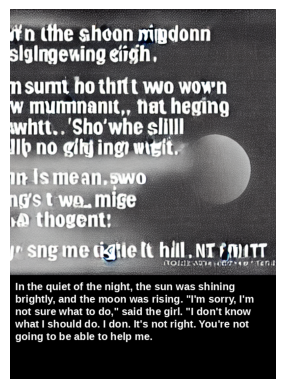

Token indices sequence length is longer than the specified maximum sequence length for this model (87 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['able to do that, then you should go.']


Image for poem 1 saved as poem_image_1.png
Generating image for poem 2...


  0%|          | 0/20 [00:00<?, ?it/s]

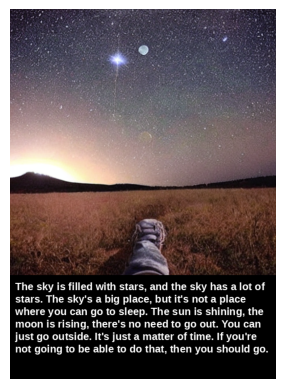

Image for poem 2 saved as poem_image_2.png
Generating image for poem 3...


  0%|          | 0/20 [00:00<?, ?it/s]

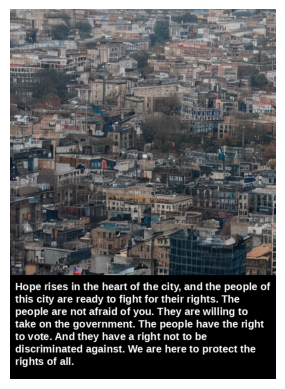

Image for poem 3 saved as poem_image_3.png
Generating image for poem 4...


  0%|          | 0/20 [00:00<?, ?it/s]

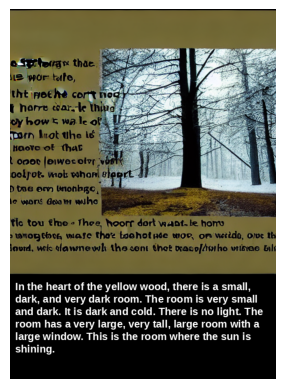

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['in this house for the rest of my life.']


Image for poem 4 saved as poem_image_4.png
Generating image for poem 5...


  0%|          | 0/20 [00:00<?, ?it/s]

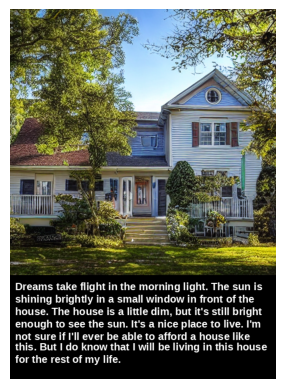

Image for poem 5 saved as poem_image_5.png


In [ ]:
#Font used
font_path = "/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf"
font = ImageFont.truetype(font_path, 20)
#Ensure the use of GPU
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe = pipe.to("cuda")
#Traverse each poem and generate corresponding images
for i, poem in enumerate(poems_five):
  print(f"Generating image for poem {i + 1}...")
  #Traverse each poem and generate corresponding images
  image = pipe(poem, num_inference_steps=20, height=512, width=512).images[0]
  #Create a new image to draw text
  img_width, img_height = image.size
  #Increase height to accommodate text
  new_height = img_height + 200
  new_image = Image.new('RGB', (img_width, new_height), color='black')
  #Paste the generated image onto a new image
  new_image.paste(image, (0, 0))
  draw = ImageDraw.Draw(new_image)
  #Processing text line breaks
  lines = []
  #Leave a margin
  max_width = img_width - 20
  current_line = ""
  for word in poem.split():
      test_line = ' '.join([current_line, word]).strip()
      #Use draw. textbbox() to get the bounding box of the text
      if draw.textlength(test_line, font=font) <= max_width:
          current_line = test_line
      else:
          lines.append(current_line)
          current_line = word
  #Add the last line
  lines.append(current_line)
  #Draw Text
  y_text = img_height + 10
  #Starting position of text
  for line in lines:
      #Get the bounding box of the text
      bbox = draw.textbbox((10, y_text), line, font=font)
      #Height
      text_height = bbox[3] - bbox[1]
      draw.text((10, y_text), line, font=font, fill="white")
      #Increase row spacing
      y_text += text_height + 5
  #Save Image
  image_path = f"poem_image_{i + 1}.png"
  new_image.save(image_path)
  #Display image
  plt.imshow(new_image)
  plt.axis("off")
  plt.show()
  print(f"Image for poem {i + 1} saved as {image_path}")

In [ ]:
!pip install diffusers

In [ ]:

!pip install pillow

# Here is a cover created for the poetry generator, aiming to inspire more creative outputs.

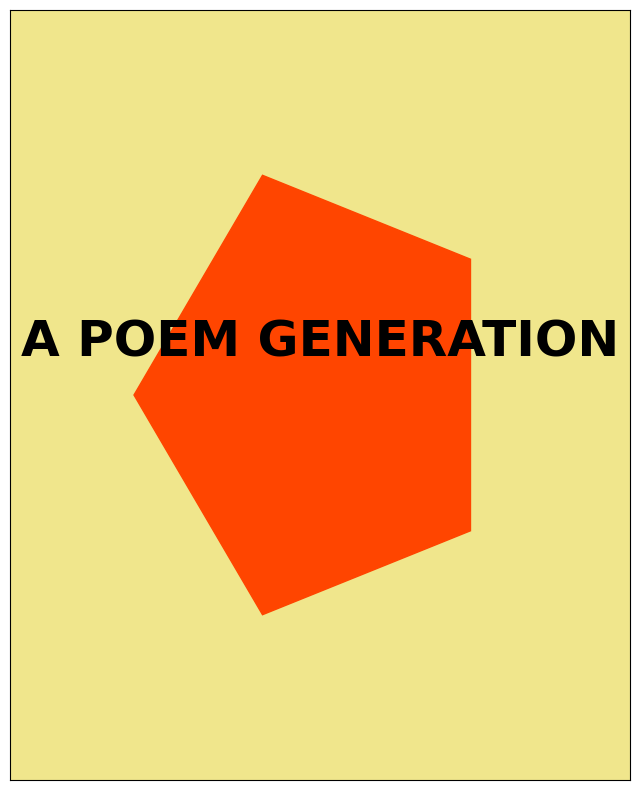

image saved 'maple_poetry_cover_manual.jpg'.


In [ ]:
#Create a blank image
fig, ax = plt.subplots(figsize=(8, 10))
#Set the background color
ax.set_facecolor('#F0E68C')
#Draw the maple leaf shape
leaf_color = '#FF4500'
leaf_shape = patches.RegularPolygon((0.5, 0.5), numVertices=5, radius=0.3, orientation=np.pi/2, color=leaf_color)
ax.add_patch(leaf_shape)
# Add text
title = "A POEM GENERATION"
#Set the font style for the title, placing it in the center
ax.text(0.5, 0.55, title, fontsize=36, ha='center', fontweight='bold', color='black')
#Hide the axes
ax.set_xticks([])
ax.set_yticks([])
#save image
output_image_path = "maple_poetry_cover_manual.jpg"
plt.savefig(output_image_path, bbox_inches='tight', dpi=300)
plt.show()
print(f"image saved '{output_image_path}'.")


In [ ]:
#Assuming the paths of your 5 images and the cover image径
image_paths = [
    "/content/poem_image_1.png",
    "/content/poem_image_2.png",
    "/content/poem_image_3.png",
    "/content/poem_image_4.png",
    "/content/poem_image_5.png",
    "/content/maple_poetry_cover_manual.jpg"
]
#Create an empty list to store images
images = []

#Open each image and add it to the list
for image_path in image_paths:
    img = Image.open(image_path)
    images.append(img)

#Open the cover image and resize it
cover_img = Image.open(image_paths[-1])
#Assuming all other images are of the same size
size = images[0].size
cover_img = cover_img.resize(size)
#Place the cover image first
images.insert(0, cover_img)
images.pop()
images = [img.convert('RGB') for img in images]
#Save as a PDF file
output_pdf_path = "poetry_collection.pdf"
images[0].save(output_pdf_path, save_all=True, append_images=images[1:])
print(f"Successfully generated PDF file: '{output_pdf_path}'.")

Successfully generated PDF file: 'poetry_collection.pdf'.


To some extent, our generated poems reffect the input theme with complete, grammatically correct sentences. The model demonstrates
creativity by producing artistic fragments, but the rhythm could be improved. We plan to incorporate more rhyming elements in future
iterations to enhance the poetic ffow. Expanding the training dataset with more diverse poetry could also enrich the vocabulary and
deepen the model’s ability to capture a range of artistic expressions. Additionally, learning from varied scenarios would improve its
understanding of linguistic diversity.

While our methods rely on learning and imitation, true creativity in poetry generation still requires more than simply following predeffned
rules. The generated poems often lack the unique stylistic expression found in human creativity. Although the model has been trained
on human language patterns, it lacks the deeper, nuanced understanding necessary for crafting poetry with a distinctive voice. As
human language evolves, machine learning must continue to adapt. Exploring new strategies to enhance the model’s capacity for creative
language generation will be crucial for future advancements.

In [ ]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 40.6 MB/s eta 0:00:00


In [ ]:
readme_content = """
# Poetry Image Collection Generator

This Jupyter Notebook is designed to generate a collection of poetry images and combine them into a single PDF file with a custom cover image.

## Features

- **Custom Cover Creation**: A maple leaf-themed cover image with a title is generated using `matplotlib`.
- **Image Loading**: Loads five poetry images.
- **PDF Generation**: Combines the poetry images, along with the custom cover, into a single PDF file.

## Prerequisites


Make sure the following Python packages are installed:

- Python：3.10
- `matplotlib`
- `PIL` (Python Imaging Library)
- `numpy`
- `diffusers` (can be installed using `!pip install diffusers`)



## Usage

1. Clone or download the notebook.
2. Prepare your poetry images and ensure they are in the correct paths (as specified in the code).
3. Run the notebook to generate a custom cover image and merge the poetry images into a PDF file.

### Steps in the Notebook:

1. **Custom Cover Creation**:
   - The notebook creates a background and draws a maple leaf shape with a poem title in the center.
   - The cover is saved as `maple_poetry_cover_manual.jpg`.

2. **Image Loading**:
   - The five poetry images are loaded, and the cover image is resized to match the dimensions of the poems.
   - The cover is inserted at the start of the list.

3. **PDF Creation**:
   - The images (cover and poems) are converted to `RGB` format.
   - The images are combined and saved as a PDF file named `poetry_collection.pdf`.

## Output

- The final output is a PDF file named `poetry_collection.pdf`, which contains the custom cover and all the poetry images.

## License

This project is open-source and free to use.

"""
with open('README.md', 'w') as f:
    f.write(readme_content)